In [1]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [2]:
import pandas as pd

# read in label class data
y = pd.read_csv("./output/label.csv")
y = y.sort_values(by = "indices").drop("indices", axis=1).to_numpy()
print(y.shape)

# read in individual sample data and store in numpy nd array
samples = 1000
take = 251 # row 1 to row 251 (exclusive), 250 rows
X = pd.read_table("./output/output1").iloc[1:take].drop("SAS", axis=1).to_numpy()
print(X[1:5, ])

for i in range(2, samples+1):
    filename = "./output/output" + str(i)
    # drop the first row (all NaNs) and drop the SAS column
    sample = pd.read_table(filename).iloc[1:take].drop("SAS", axis=1).to_numpy()
    X = np.concatenate((X, sample), axis=0)
    # print(first.shape)
# samples, rows, columns
X = X.reshape(samples, take-1, 3)

print(X[0,1:5,]) # should output the same as above, make sure re-shape did nothing weird

(1000, 1)
[[0.16563437 0.40551165 0.2100825 ]
 [0.18320036 0.38024454 0.16238518]
 [0.18356426 0.32471156 0.18220289]
 [0.11852433 0.37614929 0.21584377]]
[[0.16563437 0.40551165 0.2100825 ]
 [0.18320036 0.38024454 0.16238518]
 [0.18356426 0.32471156 0.18220289]
 [0.11852433 0.37614929 0.21584377]]


In [3]:
# flatten the data to suit the algorithm need
y = y.reshape(y.shape[0], )
X = X.reshape(samples, -1)

print(y.shape)
print(X.shape)

## train and test split 
from sklearn.model_selection import train_test_split
# set random_state (analogous to set.seed) if needed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1000,)
(1000, 750)
(800, 750)
(200, 750)
(800,)
(200,)


In [4]:
# Prepare for K fold cross validation
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

# Ideally want both high precision and high recall
# Precision: label pos + truth pos / labeled as positive
# Recall (sensitivity): label pos + truth pos / truth pos
# fl-score: harmonic mean of the precision and recall

k = 10
kf = KFold(n_splits=k, random_state = 42, shuffle=True)
fl_scores = []
accuracy = []
precision = []
recall = []
for train_index, test_index in kf.split(X_train):
    # identify the train and test set within each fold
    X_fold_train, X_fold_test = X_train[train_index], X_train[test_index]
    y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]
    
    # fit the model on the training set
    model = RandomForestClassifier(n_estimators = 500)
    model.fit(X_fold_train, y_fold_train)
    
    # predict label on validation test set, record results
    y_pred = model.predict(X_fold_test)
    precision.append(precision_score(y_fold_test, y_pred, pos_label="Yes"))
    recall.append(recall_score(y_fold_test, y_pred, pos_label="Yes"))
    fl_scores.append(f1_score(y_fold_test, y_pred, pos_label="Yes"))
    accuracy.append(accuracy_score(y_fold_test, y_pred))

print("Precision: ", np.mean(precision))
print("Recall: ", np.mean(recall))
print("F1 scores: ", np.mean(fl_scores))
print("Accuracy: ", np.mean(accuracy))

Precision:  1.0
Recall:  0.15294215931986832
F1 scores:  0.25667395257111236
Accuracy:  0.825


In [5]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# n_estimators = number of trees to bag
# clf = RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, 
#                        min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
#                        max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, 
#                        min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, 
#                        random_state=None, verbose=0, warm_start=False, class_weight=None, 
#                        ccp_alpha=0.0, max_samples=None)

model = RandomForestClassifier(n_estimators = 500, oob_score=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy on Test Set:", accuracy_score(y_test,y_pred))
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=model.oob_score_ * 100))

features = ["pi_x", "pi_y", "F_st"]
for f, imp in zip(features, model.feature_importances_):
    print('Feature {f} importance: {imp}'.format(f=f, imp=imp))
    
# pred_prob = model.predict_proba(X_test)
# print(pred_prob)

Accuracy on Test Set: 0.855
Our OOB prediction of accuracy is: 82.375%
Feature pi_x importance: 0.015667908792259627
Feature pi_y importance: 0.012193161101249489
Feature F_st importance: 0.017182325933061234


In [6]:
# Confusion Matrix for test set
df = pd.DataFrame()
df['truth'] = y_test
df['predict'] = y_pred

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict   No  Yes  All
truth                 
No       165    0  165
Yes       29    6   35
All      194    6  200


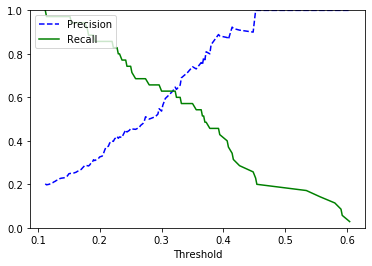

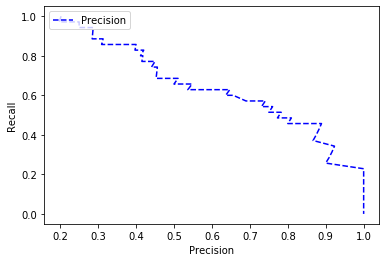

In [7]:
from sklearn.metrics import precision_recall_curve

# precision recall curve for training set 
y_prob = model.predict_proba(X_test)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob, pos_label = "Yes")

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

plt.plot(precisions, recalls, "b--", label="Precision")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="upper left")
plt.show()

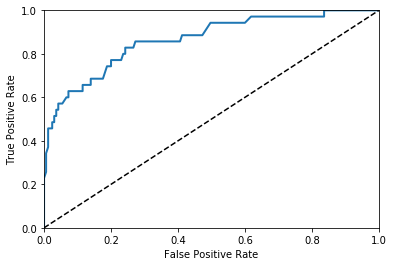

The AUC is  0.8651082251082252


In [8]:
# ROC Curve
# ROC is Receiver operating characteristic
# Sensitivity = Recall = True Positive Rate
# Specificity = True Negative Rate
# False Positive Rate = 1 — Specificity
# The more the area under the curve the better our classifier
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label = "Yes")
# fpr = false positive rate = (1 - true negative rate)
# tpr = true positive rate
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr, "Random Forest")
plt.show()

from sklearn.metrics import roc_auc_score
print("The AUC is ", roc_auc_score(y_test, y_prob))

Next steps:

Generating a diversity of inputs:

* 0.5 vs 0.5 allele frequency that produce similar patterns to SAS but is not SAS

Transfer of knowledge:

* Use existing model to predict on 0.5 vs 0.5 cases, see what prediction results we obtain

Error Analysis:
   
* Which ones are wrong? How to mitigate mistakes? Distribution of input dataset effect?
* Various metrics...

Remaining issues:

1. How to generate a diverse, well-rounded dataset covering all scenarios possible
    + Trouble: 400 windows not all valid: nan generated during Rscript
2. Fine tuning the model to archieve better results...
    + candidate statistics? approach?
3. Generating a LOT more samples on TACC, resources?
    + currently using 1000 samples, could use much more
    + current run time < 3 min on home desktop
4. Weekly report process
    + Gitlab, Github?
    + Html?